# Лабораторная работа №6

## Семантическая сегментация

Выполнил Попов Матвей, М8О-408Б-20


In [2]:
import torch, torchvision
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

In [3]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [4]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [5]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [6]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [7]:
train_dataset[0][1].shape

torch.Size([21, 256, 256])

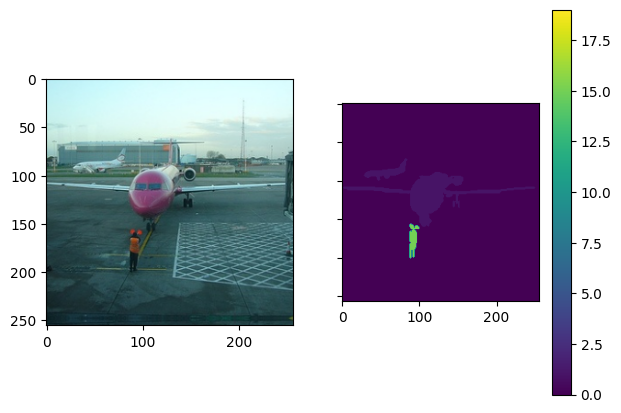

In [8]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

## Метрики IoU и MIoU

In [9]:
def IoU(real, pred):
    batch_size = real.shape[0]
    classes_num = real.shape[1]

    real = real.reshape(batch_size, classes_num, -1).long()
    pred = (
        F.one_hot(pred.argmax(axis=1), num_classes=classes_num)
        .permute(0, 3, 1, 2)
        .reshape(batch_size, classes_num, -1)
        .long()
    )

    intersection = (real & pred).sum(axis=-1)
    union = (real | pred).sum(axis=-1)
    iou = intersection / union
    return iou

def MIoU(real, pred):
    iou = IoU(real, pred)
    return iou.nanmean(axis=1)

In [10]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [11]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

/home/papey08/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/papey08/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

In [13]:
dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [14]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [15]:
r_losses = []
miou = []
rloss = 0
next_desc = "first epoch"
for epoch in range(5):

    cur_loss = 0
    cur_miou = 0
    amount = 0
    for img,lbl in tqdm(dataloader, desc = next_desc):
        predict = model(img)['out']
        loss = crit(predict, lbl)
        loss.backward()
        optim.step()
        optim.zero_grad()
        rloss += loss.detach().cpu().item() / len(dataloader)

        amount += len(img)
        cur_loss += loss.detach().cpu().item()
        cur_miou += MIoU(lbl.detach().cpu(), predict.detach().cpu()).sum()

    miou.append(cur_miou / amount)

    r_losses+= [rloss]
    next_desc = f"Epoch: [{epoch+1}], previous rloss: [{rloss:.3f}]"
    rloss = 0

Epoch: [4], previous rloss: [0.315]: 100%|██████████| 183/183 [05:35<00:00,  1.83s/it]


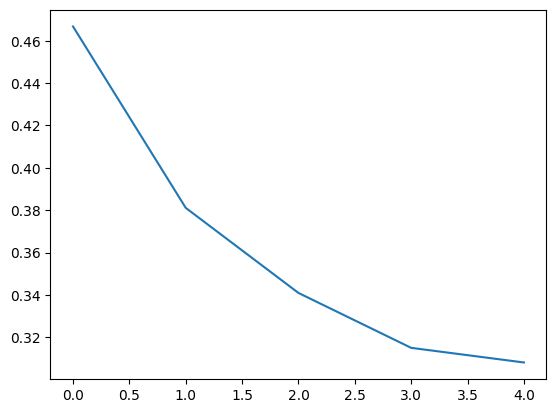

In [16]:
plt.plot(r_losses)

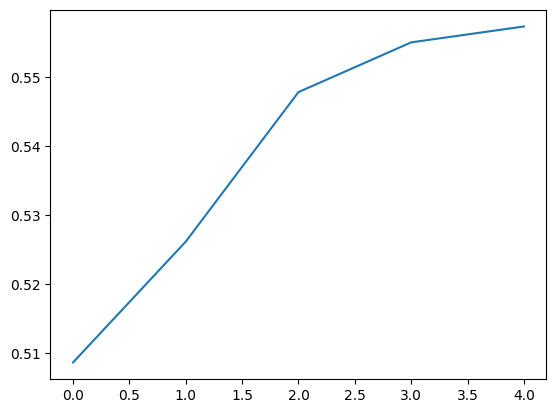

In [17]:
plt.plot(miou)

/tmp/ipykernel_102612/568789041.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


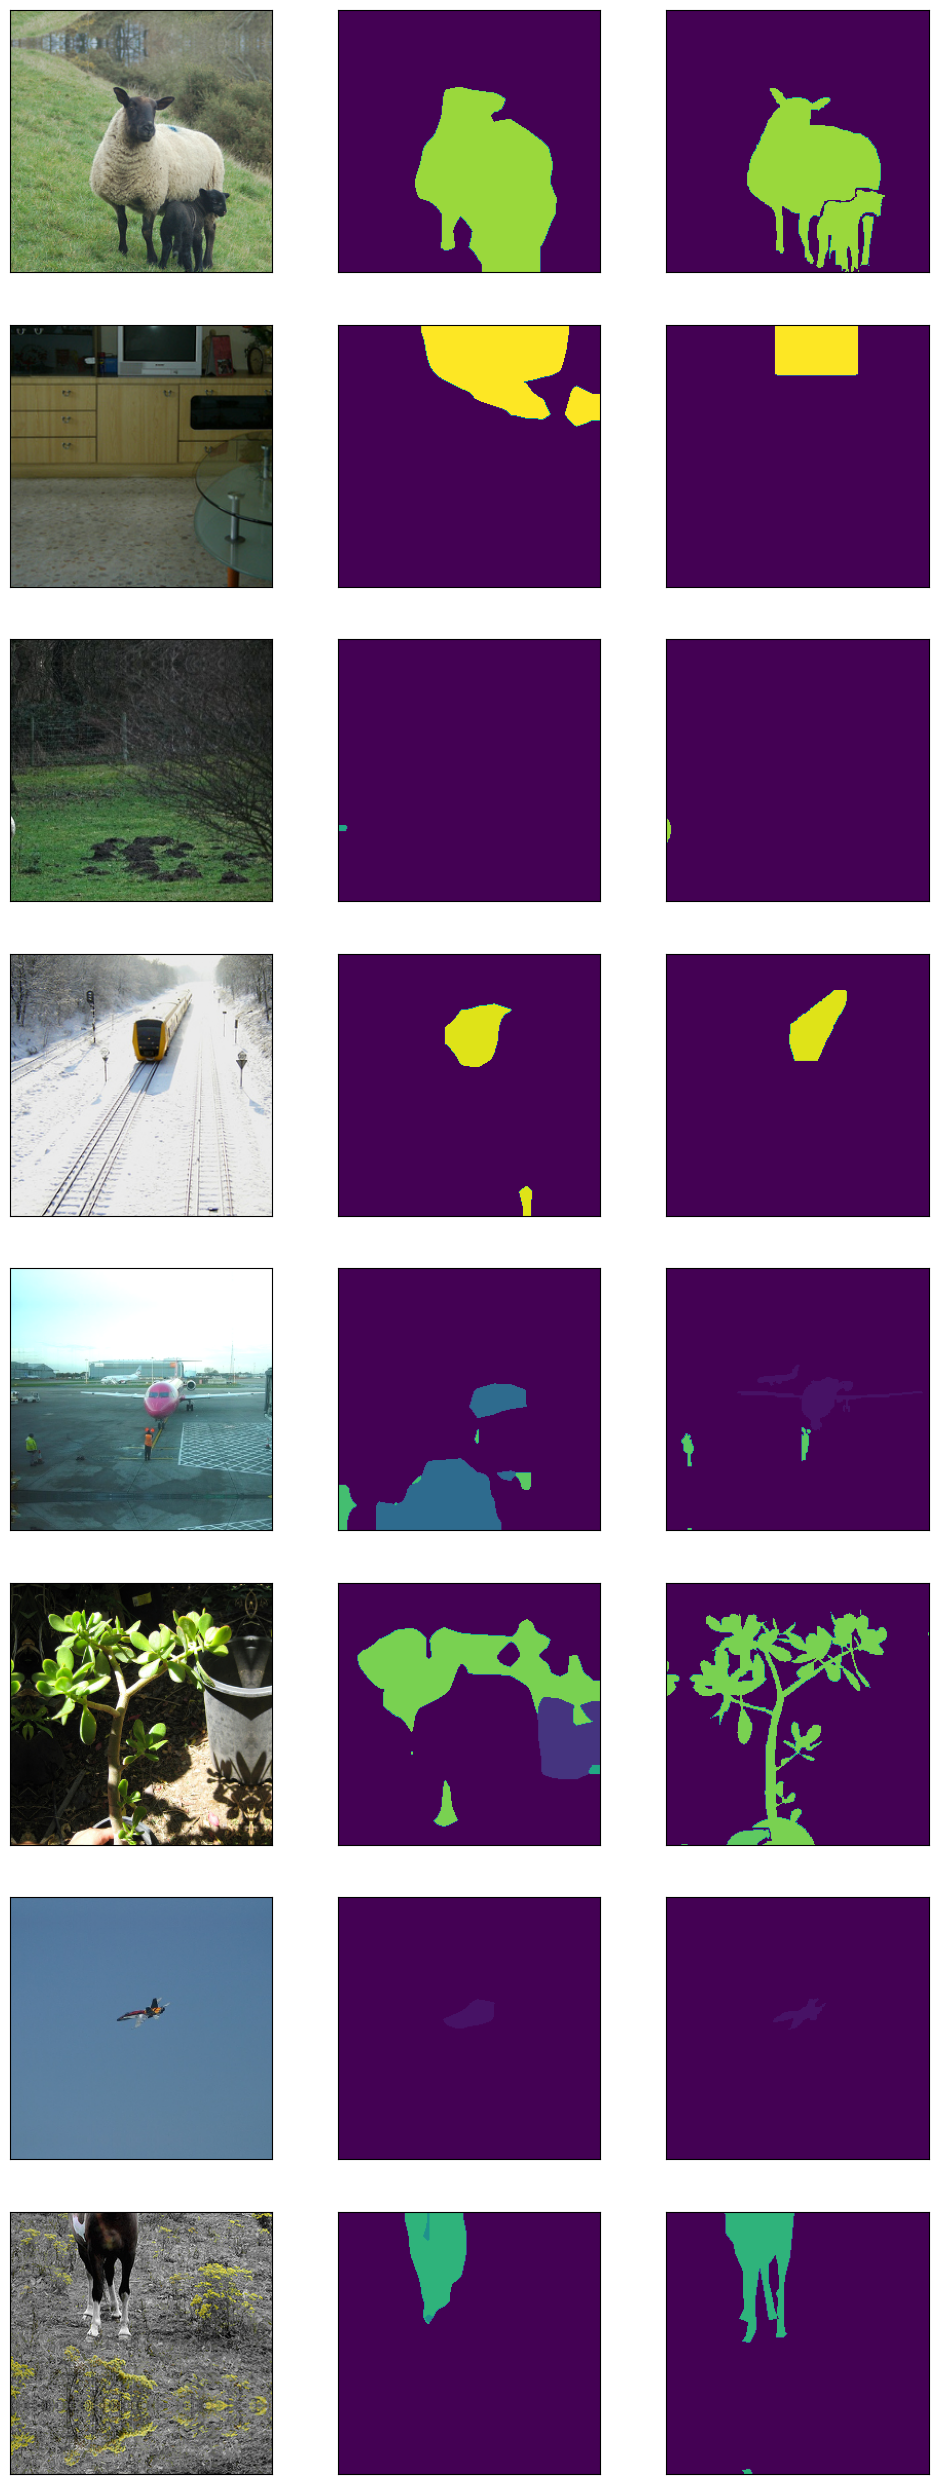

In [18]:
fig,axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))
for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()

## Вывод

Проделав лабораторную работу, я решил задачу семантической сегментации с помощью предобученной сети, расчитал метрики IoU и MIoU.
